# Imports

In [76]:
import os
from os.path import join
from time import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import numpy as np
from numpy import flatnonzero as find
from scipy.sparse import hstack, vstack
from scipy.sparse.linalg import spsolve

from data import case_as_data, PowerflowData, PowerflowOptimData

# Data hadling and description

In [77]:
c9, c57, c300 = case_as_data('case9'), case_as_data('case57'), case_as_data('case300')
pf9, pf_optim9 = PowerflowData(c9), PowerflowOptimData(c9)
pf57, pf_optim57 = PowerflowData(c57), PowerflowOptimData(c57)
pf300, pf_optim300 = PowerflowData(c300), PowerflowOptimData(c300)

A couple of words about equations:

$j$ denotes imaginary unit in electrical engineering  
$Y_{bus} = Y = G + jB$  
$S_{bus} = S = P + jQ$  
$V_i = |V_i|e^{j\delta_i}$  
$\theta_{ik} = \delta_i - \delta_k$

$S_k = V_k \cdot (YV)_k^*$  
or   
$P_{i}=\sum _{{k=1}}^{N}|V_{i}||V_{k}|(G_{{ik}}\cos \theta _{{ik}}+B_{{ik}}\sin \theta _{{ik}})$    
$Q_{i}=\sum _{{k=1}}^{N}|V_{i}||V_{k}|(G_{{ik}}\sin \theta _{{ik}}-B_{{ik}}\cos \theta _{{ik}})$  
Further reading: https://wiki.openelectrical.org/index.php?title=Power_Flow  

In the power-flow problem, it is assumed that the real power $P_D$ and reactive power $Q_D$ at each Load Bus are known. For this reason, Load Buses are also known as **PQ Buses**. For Generator Buses, it is assumed that the real power generated $P_G$ and the voltage magnitude $|V|$ is known. For this reason, Generator Buses are also known as **PV Buses**

In [78]:
def check_convergence_region(algo, problem, x_0, sigma, iterations=50, size=1000, optimization_problem = True):
    """
        Samples points from normal distribution in the vicinity of the complex x_0.
    """
    
    x_0_real = problem.V2real(x_0)
    points = np.random.normal(x_0_real, sigma, size=(size, x_0_real.shape[0]))
    points_complex = [problem.updatedV(x_0, p - x_0_real) for p in points]
    successes = []
    
    for point in tqdm(points_complex):
        x_history, values_history, times_history = algo(problem, x0=point, iterations=iterations)
        
        if optimization_problem:
            result = np.min([np.linalg.norm(problem.mismatch(x), ord=2) for x in x_history])
        else:
            result = np.min(values_history)
        if result < 1e-3 / np.sqrt(x_0_real.shape[0]):
            successes.append(1)
        else:
            successes.append(0)
    return points, successes


def draw_plots(values, times, names, log=False):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
    
    
    for name_, values_ in zip(names, values):
        axs[0].plot(values_, label=name_)
    axs[0].set_xlabel('Iteration')
    if log:
        axs[0].set_ylabel('log(value)')
        axs[0].set_yscale('log')
    else:
        axs[0].set_ylabel('Value')
        
    
    for name_, times_ in zip(names, times):
        axs[1].plot(times_, label=name_)
    
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Time, s')
    
    axs[0].grid()
    axs[1].grid()
    
    axs[0].legend()
    axs[1].legend()
    
    plt.show()
    
def summary(succeses, sigma, names):
    test_size = len(succeses[0])
    print(f'{test_size} trials each.')
    for name, succ in zip(names, succeses):
        print(f'{name}, sigma={sigma}, positive: {(np.array(succ) == 1).sum() / test_size}, negative: {(np.array(succ) == 0).sum() / test_size} ')
    

# Methods

## Newton algorthm
$$
\Delta P_{i}=-P_{i}+\sum _{{k=1}}^{N}|V_{i}||V_{k}|(G_{{ik}}\cos \theta _{{ik}}+B_{{ik}}\sin \theta _{{ik}})
\\
\Delta Q_{{i}}=-Q_{{i}}+\sum _{{k=1}}^{N}|V_{i}||V_{k}|(G_{{ik}}\sin \theta _{{ik}}-B_{{ik}}\cos \theta _{{ik}})
\\
J={\begin{bmatrix}{\dfrac  {\partial \Delta P}{\partial \theta }}&{\dfrac  {\partial \Delta P}{\partial |V|}}\\{\dfrac  {\partial \Delta Q}{\partial \theta }}&{\dfrac  {\partial \Delta Q}{\partial |V|}}\end{bmatrix}}
\\
{\begin{bmatrix}\Delta \theta \\\Delta |V|\end{bmatrix}}=-J^{{-1}}{\begin{bmatrix}\Delta P\\\Delta Q\end{bmatrix}}
\\
\theta ^{{m+1}}=\theta ^{m}+\Delta \theta \,
\\
|V|^{{m+1}}=|V|^{m}+\Delta |V|\,$$   

In [79]:
class NewtonSolver():
    def __init__(self):
        pass
    
    def __str__(self):
        return 'Newton Solver'
    
    def __repr__(self):
        return 'Newton Solver'
    
    def solve(self, regression, iterations=10, x0=None,
                 tol=1e-10, verbose=False, tqdm=False, return_best=False):
        if x0 is None:
            # special case for PowerflowDataset
            if hasattr(regression, 'get_V0'): 
                x = regression.get_V0()
            else:
                x = np.random.rand(regression.A.shape[1])
        else:
            x = x0
        
        # Convergence stop condition:
        stop = 1e-3 / np.sqrt(regression.V2real(x).shape[0])
        
        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        x_history = [x]
        values_history = [np.linalg.norm(regression.forward(x), 2)]
        grads_history = [regression.grad(x)]
        times_history = [0]
        best_values_history = [values_history[-1]]
        
        if tqdm:
            iterable = tqdm(range(iterations))
        else:
            iterable = range(iterations)
        for i in iterable:
            if verbose:
                print(f'{np.linalg.norm(regression.forward(x), 2)}')
            J = regression.grad(x)
            F = regression.forward(x)
            dx = -spsolve(J, F) # - np.linalg.inv(J.toarray()) @ F
            x = regression.updatedV(x, dx)
            
            # update histories
            x_history.append(x)
            values_history.append(np.linalg.norm(regression.forward(x), 2))
            if values_history[-1] < best_values_history[-1]:
                best_values_history.append(values_history[-1])
            else:
                best_values_history.append(best_values_history[-1])
                
            times_history.append(time() - start)
            
            if values_history[-1] <= stop:
                break   
                
        if return_best:
            return x_history, values_history, best_values_history, times_history
        else:
            return x_history, values_history, times_history

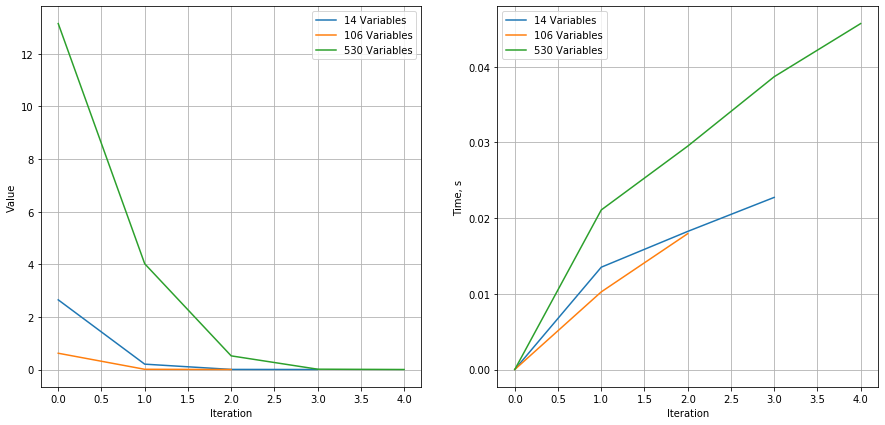

In [80]:
ns = NewtonSolver()

vals, times = [], []
for pf in [pf9, pf57, pf300]:
    res = list(ns.solve(pf, iterations=20, tol=1e-13, verbose=False))
    vals.append(res[1])
    times.append(res[-1])

draw_plots(vals, times, ['14 Variables', '106 Variables', '530 Variables'])

Seems splendid, but this was achieved with carefully choosen initial solution. Let's mess it up a little bit

Here on the Values plot values are added only if they are better then the previously obtainend minimum:

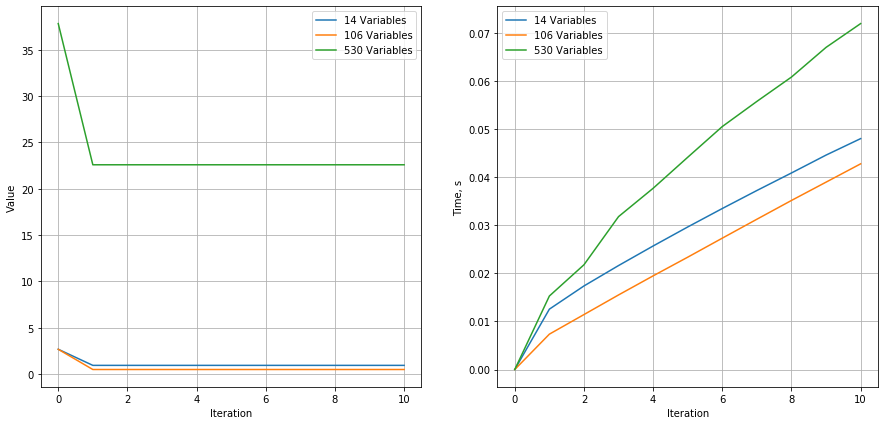

In [81]:
vals, times = [], []
for pf in [pf9, pf57, pf300]:
    res = list(ns.solve(pf, iterations=10, x0=pf.get_V0() / 2,
                        tol=1e-13, verbose=False, return_best=True))
    vals.append(res[2])
    times.append(res[-1])

draw_plots(vals, times, ['14 Variables', '106 Variables', '530 Variables'])

## Intro to optimization methods

In order to use optimization methods we need to transform our objective as following

$g = {\begin{bmatrix}\Delta P\\\Delta Q\end{bmatrix}}$

$f(x) = \sum \limits_{i=1}^{n}g_i^2(x)$

$\nabla_{x_i}f(x) = \sum \limits_{j=1}^{n} \frac{f(x)}{g_j(x)} \frac{g_j(x)}{x_i} = \sum \limits_{j=1}^{n} 2 g_j(x) J_{ji}(x) \rightarrow$

$\nabla f(x) = 2 J^T(x) \cdot g(x)$

$\nabla^2 f(x) = 2 J^T(x) J(x) + \sum \limits_{i=1}^{n} g_i(x) H_i(x)$

In case of dominance of the first term:

$\nabla^2 f(x) \approx 2 J^T(x) J(x)$

In case of equality of variables and equations Gauss-Newton method gives us:

$x_k = x_{k-1} -(J^T J)^{-1} J^T g = x_{k-1} - J^{-1} g$, which is the same as in Newton method for solving the equations. We checked the dominance for the data available - it held true. So here we will not consider the Gauss-Newton method as leading to the same results.

In case of dominance of the first term we also can use Levenberg–Marquardt regularization:

$x_k = x_{k-1} -(J^T J + \lambda I)^{-1} J^T g$, $\lambda \ge 0$

More general case $f(x) = \sum \limits_{i=1}^{n}g_i^p(x)$, $p \ge 1$ can also be considered:

$\nabla f(x) = p J^T(x) \cdot g^{p-1}(x)$

$\nabla^2 f(x) = p \cdot (p-1) J^T(x) \, \text{diag}(g^{p-2}(x)) \, J(x) + p \sum \limits_{i=1}^{n} g_i^{p-1}(x) H_i(x)$

In case of dominance of the first term:

$\nabla^2 f(x) \approx p \cdot (p-1) J^T(x) \, \text{diag}(g^{p-2}(x)) \, J(x)$

$x_k = x_{k-1} - (\nabla^2 f(x))^\dagger \nabla f(x) $

## Conjugated Gradients

In [82]:
from scipy.optimize import minimize_scalar

class ConjugateGradient():
    def __init__(self):
        pass
    
    def __str__(self):
        return 'Conjugated Gradients'
    
    def __repr__(self):
        return 'Conjugated Gradients'
    
    def optimize(self, regression, iterations=10, method='fletcher-reeves', x0=None,
                 default_step=0.01,
                line_search_iter=100, line_search_tolerance=10, tol=1e-10, use_tqdm=False):
        # random guess
        if x0 is None:
            x = np.random.rand(regression.A.shape[1])
        else: 
            x = x0
            
        # stop condition:
        stop = 1e-3 / np.sqrt(regression.V2real(x).shape[0])
        
        # conjugate direction
        d = -regression.grad(x)

        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        x_history = [x]
        values_history = [regression.normed_forward(x)]#[regression.forward(x)]
        grads_history = [regression.grad(x)]
        times_history = [0]
        
        if use_tqdm:
            iterable = tqdm(range(iterations))
        else:
            iterable = range(iterations)
        for i in iterable:
            # line search alpha
            def obj(lr):
                x_new = regression.updatedV(x, lr * d)
                return regression.forward(x_new)
            alpha = minimize_scalar(obj, bounds=(0, default_step), method='Golden',
                                    options={'maxiter':line_search_iter,
                                             'xtol': default_step / line_search_tolerance})
            if not alpha['success']:
                print(f'Line search did not converge on iteration {i}, using default step')
                alpha = default_step / (i + 1)
            else:
                alpha = alpha['x']
            
            # update x_k + 1
            if hasattr(regression, 'updatedV'): # special case for powerflowdata
                x = regression.updatedV(x, alpha * d)
            else:
                x = x + alpha * d
            x_history.append(x)
            values_history.append(regression.normed_forward(x))
            
            # compute g_k + 1
            g = regression.grad(x)
            grads_history.append(g)
            
            # update d_k + 1
            if method == 'fletcher-reeves':
                beta = (g.T @ g) / (grads_history[-2].T @ grads_history[-2])
            elif method == 'polak-ribiere':
                beta = ((g - grads_history[-2]).T @ g) / (grads_history[-2].T @ grads_history[-2])
            else:
                raise Exception(f'Unknown method: {method}')
                
            d = -g + beta * d
            
            # update times history
            times_history.append(time() - start)
            
            if values_history[-1] <= stop:
#                 print(f'Newton-Raphson converged on iteration {i}')
                break

        return x_history, values_history, times_history

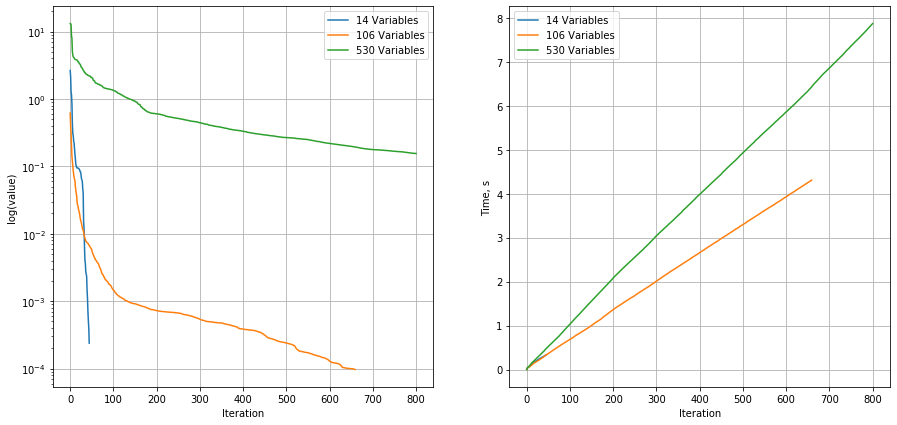

In [83]:
cg = ConjugateGradient()

vals, times = [], []
for pf in [pf_optim9, pf_optim57, pf_optim300]:
    res = list(cg.optimize(pf, x0=pf.get_V0(), method='fletcher-reeves',
                           iterations=800, line_search_iter=500, tol=1e-11,
                           use_tqdm=True))
    vals.append(res[1])
    times.append(res[-1])

draw_plots(vals, times, ['14 Variables', '106 Variables', '530 Variables'], log=True)

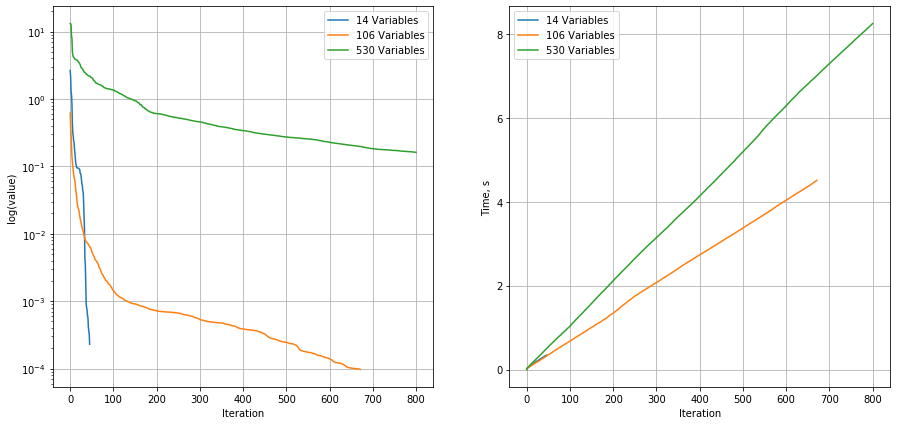

In [84]:
cg = ConjugateGradient()

vals, times = [], []
for pf in [pf_optim9, pf_optim57, pf_optim300]:
    res = list(cg.optimize(pf, x0=pf.get_V0(), method='polak-ribiere',
                           iterations=800, line_search_iter=500, tol=1e-11,
                           use_tqdm=True))
    vals.append(res[1])
    times.append(res[-1])

draw_plots(vals, times, ['14 Variables', '106 Variables', '530 Variables'], log=True)

# Nesterov's Modified Gauss-Newton

We deal with system of equation $F(x) = 0$

An important detail of the method is the assumption, that $F(x)$ has Lipschitz-continuous derivative:

$||F'(x) - F'(y)|| \le L ||x - y||$

Let's introduce merit function $\phi(u) = ||u||_2 = (\sum u_i^2)^{\frac{1}{2}}$, objective function we want to minimize $f \equiv \phi(F(x))$ and its first order model in the vicinity of the fixed point $x$:

$\psi(x, y) = \phi \big( F(x) + F'(x)(y - x) \big)$

The subproblem goes as follows. 

$V_M = \arg \min \limits_{y \in \mathbb{R}^n} \big[\psi(x, y) + \frac{1}{2}M||y - x||_2^2 \big] = \arg \min \limits_{y \in \mathbb{R}^n} \big[ ||F(x) + F'(x)(y - x)||_2 + \frac{1}{2}M||y - x||_2^2 \big]$

Let's denote $f_M(x) = \psi(x, V_M(x)) + \frac{1}{2}M||V_M(x) - x||_2^2$

Let's fix some $L_0 \in (0, L]$
The iteration of the method goes as follows:

1. Find $M_k \in [L_0, 2L]$ such that:

    $f(V_{M_k}(x_k)) < f_{M_k}(x_k)$
    

2. Set $x_{k+1} = V_{M_k}(x_k)$

In [57]:
from scipy.optimize import minimize_scalar, minimize

class ModifiedGaussNewton():
    def __init__(self):
        self.L = 0

    def __str__(self):
        return 'Modified Gauss Newton'
    
    def __repr__(self):
        return 'Modified Gauss Newton'
    
    def conv_condition(self, left, mism, jacob, vmk, xk, L):
        '''
            Assigning condition from the paper.
            
            ||F(V_{M_k}(x_k))|| < f_{M_k}(x_k)
            left part is reffered as left
            
            mism, vmk, xk : real vectors
        '''
        h = vmk - xk
        right = np.linalg.norm(mism + jacob @ h, 2) + L / 2 * h.dot(h)
        
        return left < right
    
    
    def optimize(self, regression, iterations=10, x0=None, default_step=0.01,
                line_search_iter=50, line_search_tolerance=10, tol=1e-10,
                 initial_L=1, use_tqdm=False):
        # random guess
        if x0 is None:
            x = np.random.rand(regression.A.shape[1])
        else: 
            x = x0
            
        # stop condition:
        stop = 1e-3 / np.sqrt(regression.V2real(x).shape[0])

        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        x_history = [x]
        values_history = [regression.normed_forward(x)]#[regression.forward(x)]
        grads_history = [regression.grad(x)]
        times_history = [0]
        L = initial_L
        
        
        if use_tqdm:
            iterable = tqdm(range(iterations))
        else:
            iterable = range(iterations)
        for i in iterable:
            L  = initial_L
            F = regression.mismatch(x)
            J = regression.jacobian(x)
            
            def objective(y):
                h = y - regression.V2real(x)
                res = np.linalg.norm(F + J.T @ h, 2) + L / 2 * h.dot(h)
                return res
            
#             guess = np.random.randn(*regression.V2real(x).shape)
            guess = np.zeros_like(regression.V2real(x))
            m = minimize(objective, guess, options={'maxiter':line_search_iter})
        
            if hasattr(regression, 'updatedV'): # special case for powerflowdata
                new_mismatch = regression.mismatch(regression.updatedV(x, m['x'] - regression.V2real(x)))
            else:
                new_mismatch = regression.mismatch(m['x'])
            
            while not m['success'] or \
                not self.conv_condition(np.linalg.norm(new_mismatch, 2),
                                        F, J, m['x'], regression.V2real(x), L):

                if L > 1e10:
                    print('Stopping due to L being > 1e10')
                    return x_history, values_history, times_history
                L *= 2
                
                m = minimize(objective, guess, options={'maxiter':line_search_iter})

                if hasattr(regression, 'updatedV'): # special case for powerflowdata
                    new_mismatch = regression.mismatch(regression.updatedV(x, m['x'] - regression.V2real(x)))
                else:
                    new_mismatch = regression.mismatch(m['x'])
                
            
            if hasattr(regression, 'updatedV'): # special case for powerflowdata
                x = regression.updatedV(x, m['x'] - regression.V2real(x))
            else:
                x = m['x']
            
            x_history.append(x)
            values_history.append(regression.normed_forward(x))           
            self.L = L
            # update times history
            times_history.append(time() - start)
            
            if values_history[-1] <= stop:
#                 print(f'Newton-Raphson converged on iteration {i}')
                break
        return x_history, values_history, times_history

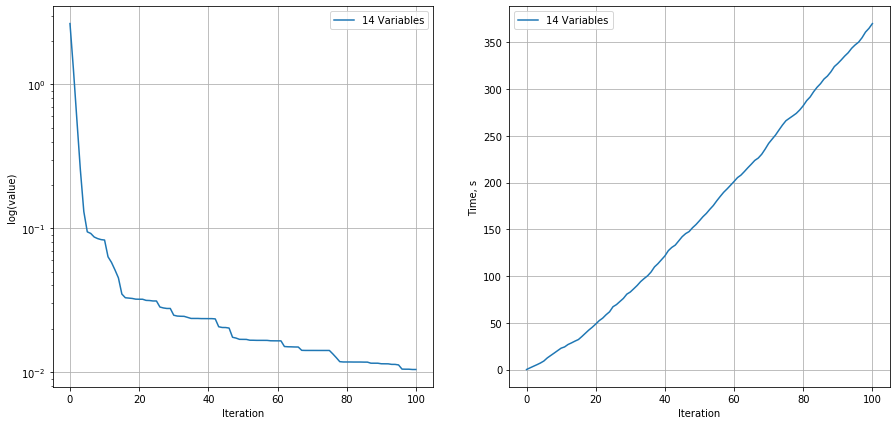

In [58]:
mgn = ModifiedGaussNewton()

vals, times = [], []
for pf in [pf_optim9]:
    res = list(mgn.optimize(pf, x0=pf.get_V0(), initial_L=1,
                           iterations=100, line_search_iter=500, tol=1e-11,
                           use_tqdm=True))
    vals.append(res[1])
    times.append(res[-1])

draw_plots(vals, times, ['14 Variables', '106 Variables', '530 Variables'], log=True)

Stopping due to L being > 1e10



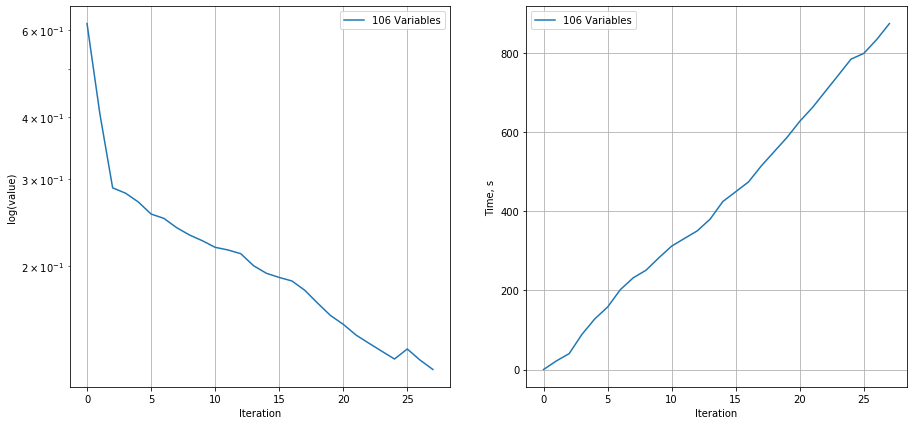

In [118]:
mgn = ModifiedGaussNewton()

vals, times = [], []
for pf in [pf_optim57]:
    res = list(mgn.optimize(pf, x0=pf.get_V0(), initial_L=1024,
                           iterations=30, line_search_iter=500, tol=1e-11,
                           use_tqdm=True))
    vals.append(res[1])
    times.append(res[-1])

draw_plots(vals, times, ['106 Variables'], log=True)

Results for case57, case300 are bad :(

## Accelerated Residuals

In [85]:
class AcceleratedResiduals():
    def __init__(self):
        pass
    
    def __str__(self):
        return 'Accelerated Residuals'
    
    def __repr__(self):
        return 'Accelerated Residuals'
    
    def optimize(self, function, x0=None, alpha=1e-5, iterations=50,
                 n=1, tol=1e-3 / np.sqrt(2), line_search_iter=100,
                 use_tqdm=False):
        """
            Works with PowerflowData
        """
        # random guess
        if x0 is None:
            u = np.random.rand(function.A.shape[1])
        else: 
            u = x0

        # stop condition:
        stop = 1e-3 / np.sqrt(function.V2real(u).shape[0])   
        
        # initialize starting time
        start = time()
        # save the history of iterations for plotting and analysis
        u_history = [u]
        values_history = [function.forward(u)]
        times_history = [0]
        
        if use_tqdm:
            pbar = tqdm(total=iterations)
        
        k = 0
        total_iters = 0
        alpha_k = alpha
        while (k <= iterations) and (total_iters <= iterations):
#             def objective_forward(alpha):
#                 return np.linalg.norm(equation.forward(u - alpha * equation.forward(u)))
            
#             alpha_k = minimize_scalar(objective_forward, bounds=(0, 1), method='bounded', options={'maxiter':line_search_iter})
#             alpha_k = alpha_k['x']
            grad = function.grad(u)
            mismatch = function.mismatch(u)
            if k == 0:
#                 print(u.shape, (- alpha_k * grad).shape)
                v_k = function.updatedV(u, - alpha_k * mismatch)
            else:
                beta_k = np.linalg.norm(mismatch, ord=2) / np.linalg.norm(function.mismatch(u_history[-2]), ord=2)
                v_k = function.updatedV(u, beta_k * (u - u_history[-2]) - alpha_k * (1 + beta_k) * mismatch)
            
            u = function.updatedV(v_k, - alpha_k * function.mismatch(v_k))
            
            u_history.append(u)
            values_history.append(function.forward(u))           
            times_history.append(time() - start)
            if np.linalg.norm(function.mismatch(u)) <= tol:
                if use_tqdm:
                    print(f'Accelerated residuals converged on iteration {total_iters}')
                for i in range(total_iters, iterations):
                    u_history.append(u_history[-1])
                    values_history.append(values_history[-1])
                    times_history.append(times_history[-1])
                break
            if k > n and values_history[-1] > values_history[-1 - n]:
                u = x_history[-2]
                k = 0
            if use_tqdm:
                pbar.update(1)
            total_iters += 1

            if values_history[-1] <= stop:
#                 print(f'Newton-Raphson converged on iteration {i}')
                break
            
            if total_iters > iterations:
                break
        return u_history, values_history, times_history

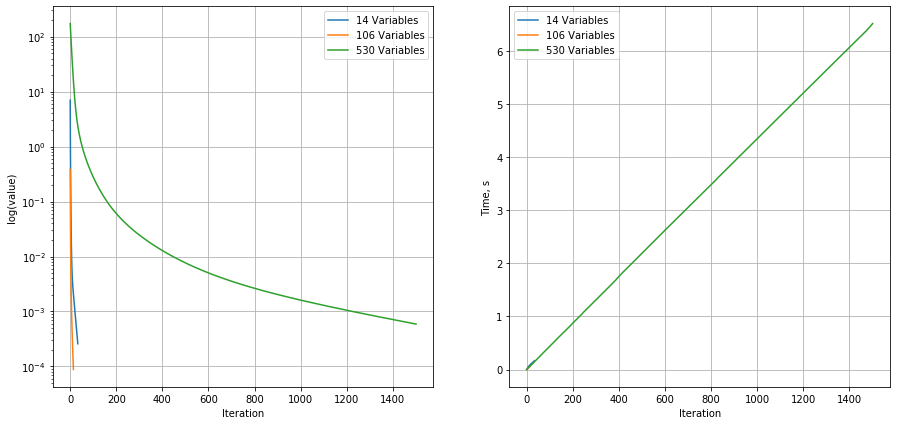

In [88]:
from functools import partial

ar = AcceleratedResiduals()

vals, times = [], []
for pf, a in zip([pf_optim9, pf_optim57, pf_optim300], [3e-2, 1e-2, 41e-5]):
    opt = partial(ar.optimize, alpha=a)
    res = list(opt(pf, x0=pf.get_V0(),
                   iterations=1500, line_search_iter=500, tol=1e-11,
                   use_tqdm=False))
    vals.append(res[1])
    times.append(res[-1])

draw_plots(vals, times, ['14 Variables', '106 Variables', '530 Variables'], log=True)

# Convergence area comparison

In [65]:
ns = NewtonSolver()
cg = ConjugateGradient()
mgn = ModifiedGaussNewton()
ar = AcceleratedResiduals()

cg_fr = partial(cg.optimize, line_search_iter=500, method='fletcher-reeves')
cg_pr = partial(cg.optimize, line_search_iter=500, method='polak-ribiere')
mgn_opt = partial(mgn.optimize, line_search_iter=500, initial_L=1)
ar9, ar57, ar300 = [partial(ar.optimize, alpha=a) for a in [3e-2, 1e-2, 40e-5]]

In [67]:
pf, pf_optim = pf9, pf_optim9
names = [ns.__str__(), cg.__str__() + ' fletcher-reeves', 
         cg.__str__() + ' polak-ribiere', ar.__str__()]
algs = [ns.solve, cg_fr, cg_pr, ar9]
sigma = 0.3
data = [pf] + [pf_optim] * 3

successes = []
for alg, pf in zip(algs, data):   
    _, succ = check_convergence_region(alg, pf, pf.get_V0(), sigma=sigma, 
                                       size=100, iterations=500, 
                                       optimization_problem=False)
    successes.append(succ)
    
print('For problem size of 14')
summary(successes, sigma, names)


For problem size of 14
100 trials each.
Newton Solver, sigma=0.3, positive: 0.24, negative: 0.76 
Conjugated Gradients fletcher-reeves, sigma=0.3, positive: 0.55, negative: 0.45 
Conjugated Gradients polak-ribiere, sigma=0.3, positive: 0.76, negative: 0.24 
Accelerated Residuals, sigma=0.3, positive: 0.99, negative: 0.01 


In [97]:
pf, pf_optim = pf57, pf_optim57

names = [ns.__str__(), cg.__str__() + ' fletcher-reeves', 
         cg.__str__() + ' polak-ribiere', ar.__str__()]
algs = [ns.solve, cg_fr, cg_pr, ar57]
sigma = 0.04
data = [pf] + [pf_optim] * 3

successes = []
for alg, pf in zip(algs, data):   
    _, succ = check_convergence_region(alg, pf, pf.get_V0(), sigma=sigma, 
                                       size=100, iterations=500, 
                                       optimization_problem=False)
    successes.append(succ)
    
print('For problem size of 106')
summary(successes, sigma, names)


For problem size of 106
100 trials each.
Newton Solver, sigma=0.04, positive: 0.68, negative: 0.32 
Conjugated Gradients fletcher-reeves, sigma=0.04, positive: 0.0, negative: 1.0 
Conjugated Gradients polak-ribiere, sigma=0.04, positive: 0.0, negative: 1.0 
Accelerated Residuals, sigma=0.04, positive: 1.0, negative: 0.0 


In [105]:
pf, pf_optim = pf300, pf_optim300

names = [ns.__str__(), cg.__str__() + ' fletcher-reeves', 
         cg.__str__() + ' polak-ribiere', ar.__str__()]
algs = [ns.solve, cg_fr, cg_pr, ar300]
sigma = 0.03
data = [pf] + [pf_optim] * 3

successes = []
for alg, pf in zip(algs, data):   
    _, succ = check_convergence_region(alg, pf, pf.get_V0(), sigma=sigma, 
                                       size=100, iterations=500, 
                                       optimization_problem=False)
    successes.append(succ)
    
print('For problem size of 530')
summary(successes, sigma, names)

/Users/litleo/Code/skoltech/large_scale_optimization/nonlinear-opt/code/pypower/dSbus_dV.py:60: RuntimeWarning: overflow encountered in true_divide
  diagVnorm = sparse((V / abs(V), (ib, ib)))
/Users/litleo/opt/miniconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:198: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)



For problem size of 530
100 trials each.
Newton Solver, sigma=0.03, positive: 0.76, negative: 0.24 
Conjugated Gradients fletcher-reeves, sigma=0.03, positive: 0.0, negative: 1.0 
Conjugated Gradients polak-ribiere, sigma=0.03, positive: 0.0, negative: 1.0 
Accelerated Residuals, sigma=0.03, positive: 0.0, negative: 1.0 
